# Predicting Churn of Telecommunication Customers using Classification Machine Learning Strategies on Data of their Customer Usage and Services

## Opening Statement:
Interconnect, a telecommunications operator would like to predict the churn of their clients. In this project I'm going to be using the data from 4 different CSV files to create one more complete picture of their collected information. Then I will create new features that will be helpful for the overall goal of predicting churn. Finally, I will be building a machine learning model that will be able to predict with an AUC-ROC score of higher than .85. Once that minimum metric has been acheived I will propose the model that gives the best chance of predicting churn so that Interconnect can create strategies to reduce the churn of clients.

In [ ]:
# Import Packages and Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# Metrics
from sklearn.metrics import roc_auc_score, accuracy_score

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
# Read Data sets
contract = pd.read_csv('contract.csv')
internet = pd.read_csv('internet.csv')
personal = pd.read_csv('personal.csv')
phone = pd.read_csv('phone.csv')

## Contract CSV

In [ ]:
# first look at the Contract data. This contains the eventual Target information
display(contract.head())
print()
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
print('Payment Methods:', contract['PaymentMethod'].unique())

Payment Methods: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [ ]:
contract['BeginDate'].min()

'2013-10-01'

In [ ]:
# Check for class imbalance
current_customers = len(contract[contract['EndDate'] == 'No']) / len(contract['EndDate'])
print(f'Percentage of data that are current customers: {current_customers*100:.1f}%')

Percentage of data that are current customers: 73.5%


### Contract Observations
The contract CSV file contains the target information of this task in the current end date column. There are currently 7043 observations and no missing values in this data set. As seen above, there is a class imbalance issue with 73.5% of the clients in this data continuing to use Interconnect Services. This class imbalance will need to be addressed in order to create a quality predictive model for this project. 

Some additional considerations include: needing to change the Total Charges column datatype to float instead of object. I will also need to rename the columns into snake case and use the begin and end date columns to create a contract length feature. 

In the Payment Method column there is parenthetical information about automatic vs. manual payments. I would like to explore in the EDA portion whether there is any difference in churn based on these different methods, or if they could be simplified into Automatic or Manual categories.

There are 3 different contract types: Monthly, Annual, and Biannual. I would like to see how many customers are in each type of contract, and what the correlation is between each of these categories and the churn rate as well.


## Internet CSV

In [ ]:
display(internet.head())
print()
print(internet.info())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


In [ ]:
print(internet['InternetService'].unique())

['DSL' 'Fiber optic']


### Internet Observations

The Internet CSV file contains information on the services that are included in the contract for each customer. This file only contains 5517 observations, suggesting that there are some clients that have contracts with Interconnect that do not have internet service with them. When I merge the data of this file there will be missing values. These values will need to be filled with meaningful information. 

There are two types of service offered: DSL and Fiber Optic. The other columns in this data are either yes or no columns on whether or not the client has opted into each additional feature offered.


## Personal CSV

In [ ]:
display(personal.head())
print()
print(personal.info())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


In [ ]:
print(personal['SeniorCitizen'].unique())

[0 1]


### Personal Observations
This CSV file contains the demographic information about the customers. It contains all 7043 observations on each customer and there are no missing values. The Senior citizen column is currently int type and will need to be converted to object as the values in it are either 0 or 1 for yes or no. 


## Phone CSV ##

In [ ]:
display(phone.head())
print()
print(phone.info())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


In [ ]:
print(phone['MultipleLines'].unique())

['No' 'Yes']


### Phone Observations
The phone CSV file contains 6361 observations and only two columns. One of the columns is the unique customer ID, and the other is whether this customer has multiple lines or just one. As was true with the other CSV files there are no missing values to be concerned with in the original data. However, because there are less obeservations recorded than in the Contract and Personal files, there will be missing values once merged to the whole data set. As a result, the missing data will need to be filled with an Unknown value.


## Workflow Plan:

1. Load Data
2. EDA - explore the data so that I know how to best handle it during the preprocessing stage, and to develop some hypotheses for 
3. Preprocess
    * Merge the data based on the Customer ID columns from each data set
    * Fill missing information - at this point, I'm thinking I will fill it with 'unknown'
    * Correct the column names
    * Change data types of key columns - Total Charges needs to be float, Senior Citizen needs to be object
    * Perform additional EDA to develop an in depth understanding of our data
4. Feature Engineering
    * Define the Target Column with either a 0 or 1 for classification
    * Calculate the length of contract using February 1, 2020 as the current date
    * Conduct One-Hot Encoding on the categorical data
    * Address class imbalance using SMOTE or Upsampling
5. Split the data into Training and Test sets: 20% split
6. Train classification models
    * Random Forest
    * Logistic Regression
    * LGBM
    * XGBoost
7. Evaluate using AUC-ROC and Accuracy
8. Hyperparameter tuning
    * Determine which models provide the best initial results
    * Perform parameter grid testing on each of the best models
9. Test final model
    * Determine which model produces the best predictions with the training set and pass the test set to it.
    * Correct for any overfitting
10. Conclusion
    * Show the results of the test
    * Make a recommendtion to Interconnect on which model will most effectively predict churn


### Clarifying Questions

1. Because I'm expecting there to be a lot of NaN values once I merge the data, and these data files are too small to reasonably drop them, I am planning to fill that data in with 'Unknown' for most areas. My thought is that since  most of this data is categorical adding Unknown is just adding one more category. Is there a better approach than that?

2. I've assumed that the data in the internet column is whether or not the customer opted into those particular offerings of service, is that correct?

3. I can see the need to add a few features such as: Contract length, the actual target churn, and maybe automatic vs manual payment methods. Aside from these I'm having a hard time seeing additional information to calculate. Are there additional features that I need to be considering to effectively set up this project?


## Preprocessing and Feature Engineering

In [ ]:
# change the column names to snake case

# Contract
contract.rename(columns={'customerID': 'customer_id', 'BeginDate': 'begin_date', 'EndDate': 'end_date', 'Type': 'type', 'PaperlessBilling': 'paperless_billing', 'PaymentMethod': 'payment_method', 'MonthlyCharges': 'monthly_charges', 'TotalCharges': 'total_charges'}, inplace=True)

# Internet
internet.rename(columns={'customerID': 'customer_id', 'InternetService': 'internet_service', 'OnlineSecurity': 'online_security', 'OnlineBackup': 'online_backup', 'DeviceProtection': 'device_protection', 'TechSupport': 'tech_support', 'StreamingTV': 'streaming_tv', 'StreamingMovies': 'streaming_movies'}, inplace=True)

# Personal
personal.rename(columns={'customerID': 'customer_id', 'SeniorCitizen': 'senior_citizen', 'Partner': 'partner', 'Dependents': 'dependents'}, inplace=True)

# Phone
phone.rename(columns={'customerID': 'customer_id', 'MultipleLines': 'multiple_lines'}, inplace=True)

In [ ]:
# Make target column called 'churn'
contract['churn'] = np.where(contract['end_date'] == 'No', 0, 1)

In [ ]:
# Change begin date to datetime
contract['begin_date'] = pd.to_datetime(contract['begin_date'])

# Fix the end_date column
contract['end_date'] = contract['end_date'].astype(str).str.strip()

# Convert end_date to datetime
contract['end_date'] = pd.to_datetime(contract['end_date'], errors='coerce', format='%Y-%m-%d %H:%M:%S')


contract['end_date'] = contract['end_date'].fillna('2020-02-01')

contract['end_date'] = contract['end_date'].dt.strftime('%Y-%m-%d')
contract['end_date'] = pd.to_datetime(contract['end_date'])

In [ ]:
# Create the contract_length feature
contract['contract_length'] = contract['end_date'] - contract['begin_date']

# change it to an int dtype
contract['contract_length'] = contract['contract_length'].dt.days.astype(int)

In [ ]:
# convert total_charges column to float
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')

# check for NaN values
print(contract['total_charges'].isna().sum())

11


In [ ]:
# Correct personal at senior_citizen to follow the same structure as the other columns
personal['senior_citizen'] = np.where(personal['senior_citizen'] == 0, 'No', 'Yes')

In [ ]:
personal['senior_citizen'].value_counts()

senior_citizen
No     5901
Yes    1142
Name: count, dtype: int64

In [ ]:
# Mere the data from each dataframe
merged_df = (
    contract.merge(personal, on='customer_id', how='left')
    .merge(internet, on='customer_id', how='left')
    .merge(phone, on='customer_id', how='left')
)

print(merged_df.shape)
display(merged_df.head())

(7043, 22)


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,contract_length,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [ ]:
# Remove columns that are not helpful for the final model building
df = merged_df.drop(columns=['customer_id', 'begin_date', 'end_date'])


In [ ]:
# Drop the 11 rows that have NaN in the total charges column
df = df.dropna(subset=['total_charges'])


In [ ]:
# Fill the NaN values in the rest of the data with Unknown
df = df.fillna('Unknown')

# verify that there are no longer any null values                                               
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   churn              7032 non-null   int32  
 6   contract_length    7032 non-null   int32  
 7   gender             7032 non-null   object 
 8   senior_citizen     7032 non-null   object 
 9   partner            7032 non-null   object 
 10  dependents         7032 non-null   object 
 11  internet_service   7032 non-null   object 
 12  online_security    7032 non-null   object 
 13  online_backup      7032 non-null   object 
 14  device_protection  7032 non-null   object 
 15  tech_support       7032 non-null   object 
 16  streaming_tv       7032 non-n

## EDA ##

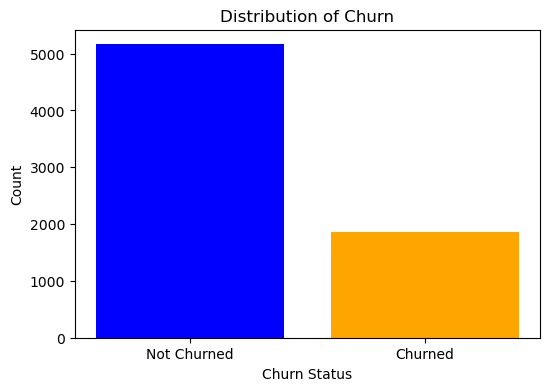

In [ ]:
# Show the class inequity using a bar chart
churn_counts = df['churn'].value_counts()
plt.figure(figsize=(6,4))
plt.bar(churn_counts.index, churn_counts.values, color=['blue', 'orange'])
plt.xticks(ticks=[0,1], labels=['Not Churned', 'Churned'])
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.title('Distribution of Churn')
plt.show()

There is not an even distribution of churn, so when it comes time to split the data I will need to upsample the churned observations.

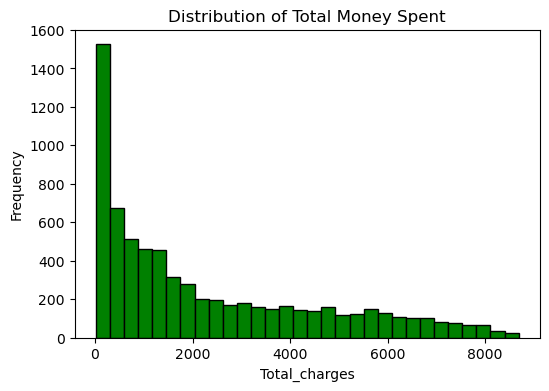

In [ ]:
# Show the amount of money that people have spent with interconnect
plt.figure(figsize=(6,4))
plt.hist(df['total_charges'], bins=30, edgecolor='black', color='green')
plt.xlabel('Total_charges')
plt.ylabel('Frequency')
plt.title('Distribution of Total Money Spent')
plt.show()

The high spike at low end of total money spent suggests that there are likely a lot of new customers. This could account for why there are not many churn observations yet.

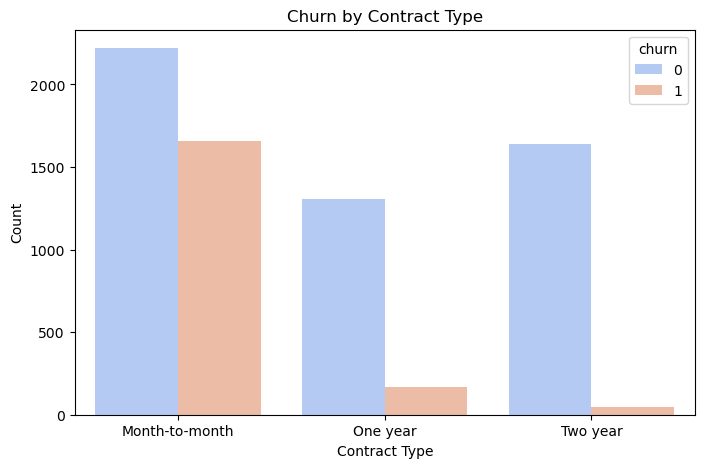

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='type', hue='churn', palette='coolwarm')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.title('Churn by Contract Type')
plt.show()

The vast majority of the churn examples come from clients that are in the month-to-month category of payment. Those who commit to a 2 year cycle are staying longer. This could also be a sampling issue - the data only spans from 2013 - 2020. So there might not have been enough cycles of 2 year contracts to make those observations higher. But given that the one year contract also shows significantly less churn, it would suggest that the month-to-month customers are more likely to leave than the long term contracts.

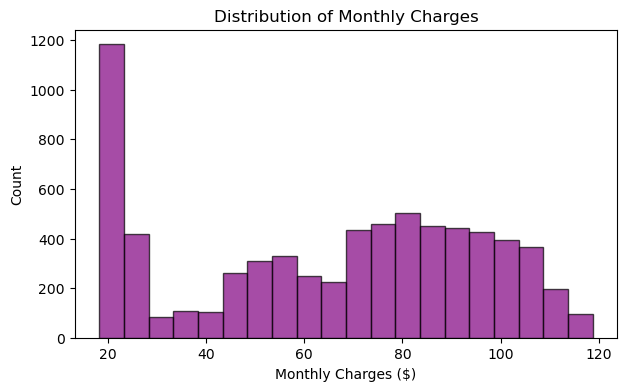

In [ ]:
plt.figure(figsize=(7, 4))
plt.hist(df['monthly_charges'], bins=20, color='purple', edgecolor='black', alpha=0.7)
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Count')
plt.title('Distribution of Monthly Charges')
plt.show()

There is a large portion of the contracts that are in the low $20 range of payment. And then there is an more normal distribution of payments that peak around $80. It may be helpful to compare monthly charges to churn to see if there is a connection.

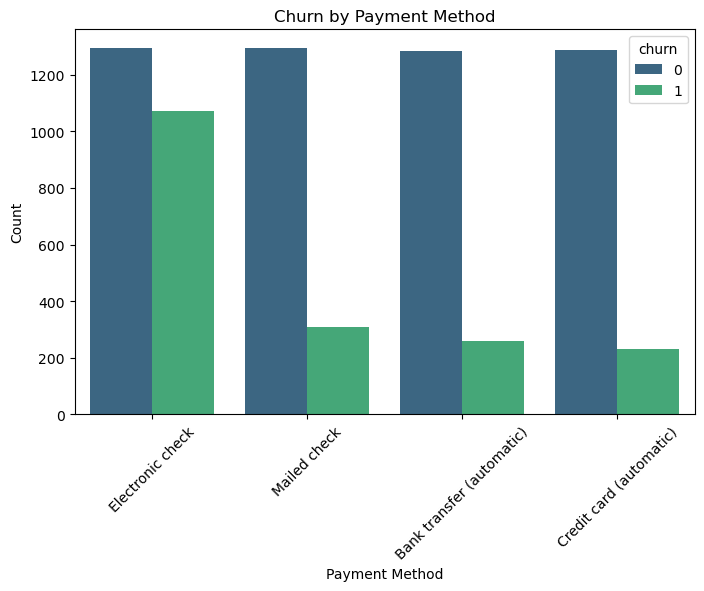

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='payment_method', hue='churn', palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.title('Churn by Payment Method')
plt.show()

This chart shows that the most likely customers to churn are those that are using the Electronic Check payment method. I'm very curious to know what is going on here. I wonder if this system may be more complicated for customers to use, or if it has resulted in missed payments that have large fees associated with. What history does this company have with the e-check payment method?

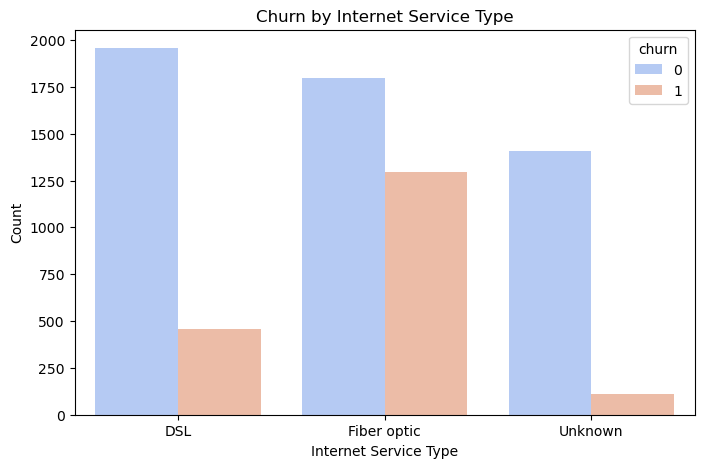

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='internet_service', hue='churn', palette='coolwarm')
plt.xlabel('Internet Service Type')
plt.ylabel('Count')
plt.title('Churn by Internet Service Type')
plt.show()

This one is facinating - more clients churn who signed up for Fiber Optic internet instead of DSL. This more than double increase suggests that this may be an issue with the companies service offered. What kind of issues did Interconnect run into while implementing Fiber, and perhaps - where are these accounts located vs the DSL accounts. Could it be possible that F.O. is offered in areas with more competition so customers have more options for leaving?

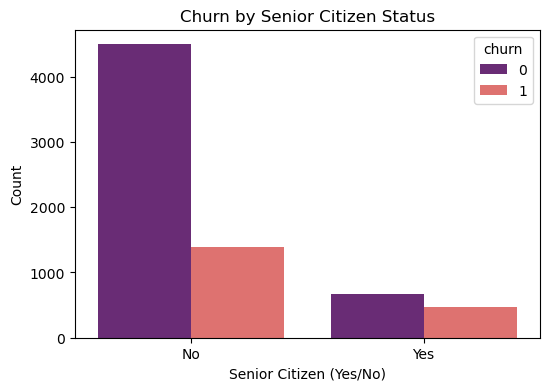

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='senior_citizen', hue='churn', palette='magma')
plt.xlabel('Senior Citizen (Yes/No)')
plt.ylabel('Count')
plt.title('Churn by Senior Citizen Status')
plt.show()

While most of Interconnects clients are not Senior Citizens, there seems to be a higher likelihood that seniors will leaving Interconnect. I'd be curious if other companies see a similar trend. Still, the churn observations are still higher in the non-senior class, but proportionately there seems to be an issue with how Interconnect is interacting with Senior citizens. More exploration will be needed to try to fix this issue.

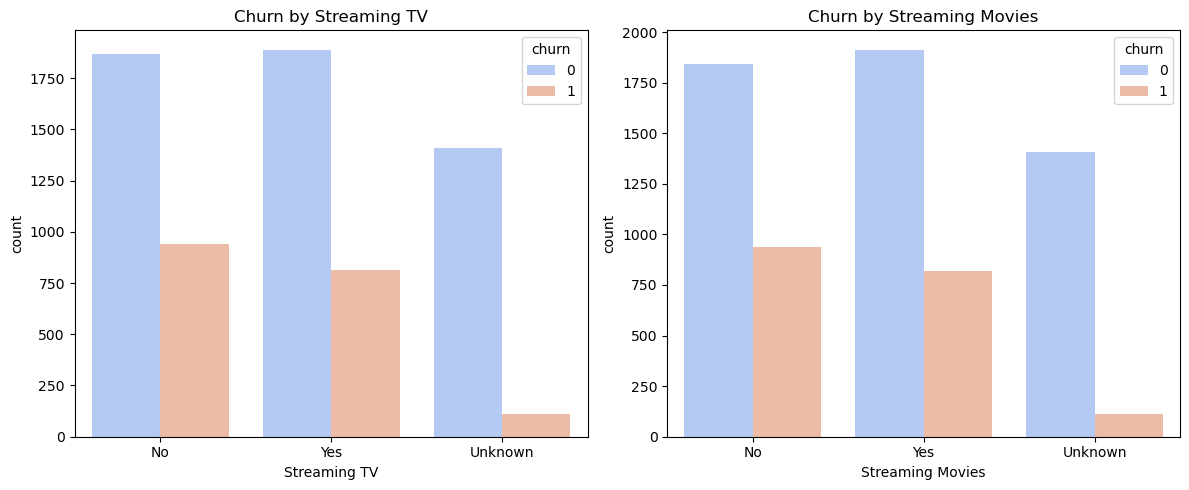

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Streaming TV
sns.countplot(data=df, x='streaming_tv', hue='churn', palette='coolwarm', ax=axes[0])
axes[0].set_title('Churn by Streaming TV')
axes[0].set_xlabel('Streaming TV')

# Streaming Movies
sns.countplot(data=df, x='streaming_movies', hue='churn', palette='coolwarm', ax=axes[1])
axes[1].set_title('Churn by Streaming Movies')
axes[1].set_xlabel('Streaming Movies')

plt.tight_layout()
plt.show()

There is not an obvious trend that suggests that clients that use streaming services or not are more likely to churn. This might not actually be a highly relevant feature for our eventual machine learning. If the model is struggling to attain a high enough AucRoc Score, this could be a feature to consider removing due to the potential of noise.

C:\Users\markl\AppData\Local\Temp\ipykernel_13888\1950169441.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="churn", y="monthly_charges", palette="coolwarm")


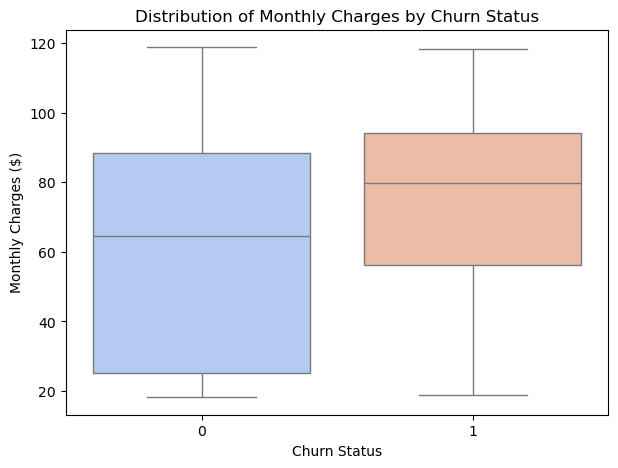

In [ ]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x="churn", y="monthly_charges", palette="coolwarm")
plt.xlabel("Churn Status")
plt.ylabel("Monthly Charges ($)")
plt.title("Distribution of Monthly Charges by Churn Status")
plt.show()

The churn class has a significantly higher montly charge window in the chart above. The average monthly bill is above $80, whereas the average bill for those that are still with Interconnect is just above $60. This could be a major contributor to the churn problem. People want to believe that they're getting their money's worth. What is causing these customers to have higher monthly charges - are there late fees connected to them, or are they signed up for more exspensive services? 

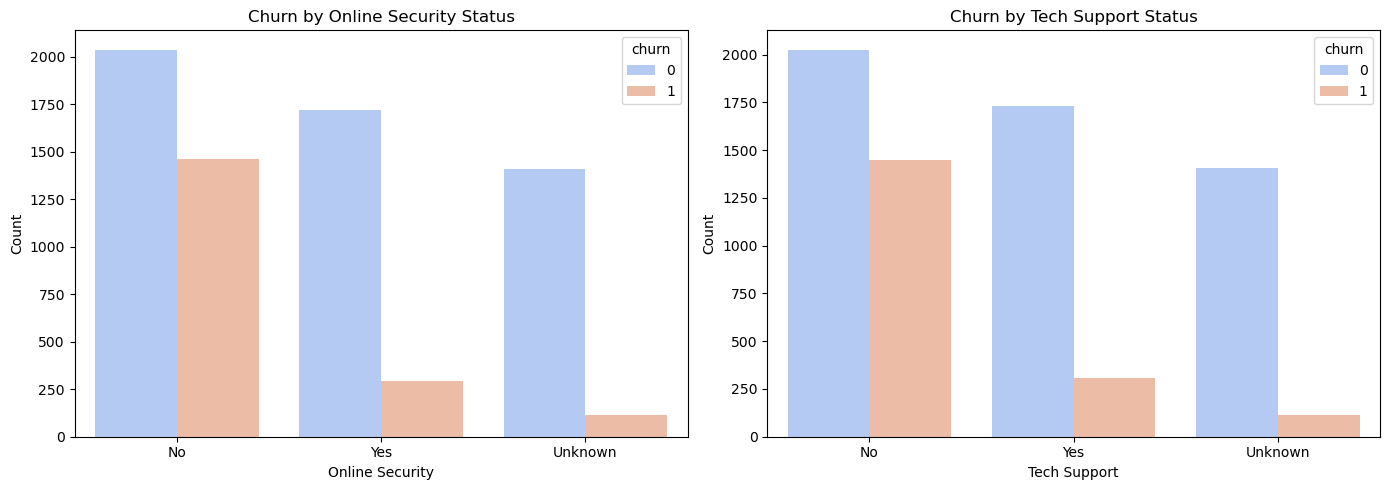

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


sns.countplot(data=df, x="online_security", hue="churn", palette="coolwarm", ax=ax1)
ax1.set_xlabel("Online Security")
ax1.set_ylabel("Count")
ax1.set_title("Churn by Online Security Status")



sns.countplot(data=df, x="tech_support", hue="churn", palette="coolwarm", ax=ax2)
ax2.set_xlabel("Tech Support")
ax2.set_ylabel("Count")
ax2.set_title("Churn by Tech Support Status")

plt.tight_layout()

plt.show()

Above we can see that there is a lower churn rate with the clients that are signed up for some of the extra services such as Online Security Status and Tech Support. There may actually not be any variation between the customers that have one over the other.

### EDA Conclusions ###
There is quite a lot of variation in the data to suggest that we'll be able to find which clients are most likely to leave Interconnect. The churn examples in this data are quite a lot fewer, so we will need to conduct SMOTE or upsampling to balance the data for Machine Learning. There are many features that are either yes or no observations so this will not cause a massive amount of extra features when we conduct one-hot-encoding.

## Address class imbalance ##

In [ ]:
# One-Hot encoding on categorical data

# define categorical columns
categorical_columns = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner',
                        'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection',
                          'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

# One-Hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

display(df_encoded.head())
df_encoded.shape

,monthly_charges,total_charges,churn,contract_length,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,...,device_protection_Unknown,device_protection_Yes,tech_support_Unknown,tech_support_Yes,streaming_tv_Unknown,streaming_tv_Yes,streaming_movies_Unknown,streaming_movies_Yes,multiple_lines_Unknown,multiple_lines_Yes
0,29.85,29.85,0,31,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,True,False
1,56.95,1889.50,0,1036,True,False,False,False,False,True,...,False,True,False,False,False,False,False,False,False,False
2,53.85,108.15,1,61,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,42.30,1840.75,0,1371,True,False,False,False,False,False,...,False,True,False,True,False,False,False,False,True,False
4,70.70,151.65,1,61,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False


(7032, 30)

In [ ]:
# clean the columns after the one-hot-encoding
df_encoded.columns = df_encoded.columns.str.replace(" ", "_")

In [ ]:
# Using SMOTE
X = df_encoded.drop(columns=['churn'])
y = df_encoded['churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=8420, stratify=y)

smote = SMOTE(random_state=8420)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Show class distribution before and after SMOTE
print('Before SMOTE: \n', y_train.value_counts())
print('After SMOTE:\n', y_train_resampled.value_counts())

Before SMOTE: 
 churn
0    4130
1    1495
Name: count, dtype: int64
After SMOTE:
 churn
0    4130
1    4130
Name: count, dtype: int64


In [ ]:
# When initially making models I found that there are several columns that have almost no importance for model building. So I'm going to drop those columns here.
unknown_cols = [col for col in X_train_resampled.columns if 'Unknown' in col]
X_train_resampled = X_train_resampled.drop(columns=unknown_cols)
X_test = X_test.drop(columns=unknown_cols)
print(f'dropped {len(unknown_cols)}"Unknown" columns')

dropped 8"Unknown" columns


## Train Models ##

I will use Random Forest, Logistic Regression, LightGBM and XGBoost. 

The metric that I'm most interested in optimizing is the Auc-Roc Score. Secondarily I want to see the effect of training on the Accuracy score. 

The minimum passing score for the Auc-Roc score is: .85
The threshold for maximum points is above: .88

In [ ]:
# Make a model testing function
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    # train the model
    model.fit(X_train, y_train)

    # make predictions
    test_predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)

    # Evaluate the model
    train_auc_roc = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    test_auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    accuracy = accuracy_score(y_test, test_predictions)

    print(f'Train Auc-Roc: {train_auc_roc:.2f}')
    print(f'Test AUC-ROC: {test_auc_roc:.2f}')
    print(f'Test Accuracy: {accuracy:.2f}')

    return train_auc_roc, test_auc_roc, accuracy



### Random Forest Classifer

In [ ]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 8],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5]
}

# Initialize model
rf = RandomForestClassifier()

# Perform grid search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters
print(grid_search.best_params_)


{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_leaf=2, min_samples_split=5, random_state=8420)
train_auc_roc, test_auc_roc, accuracy = train_evaluate_model(rf, X_train_resampled, y_train_resampled, X_test, y_test)

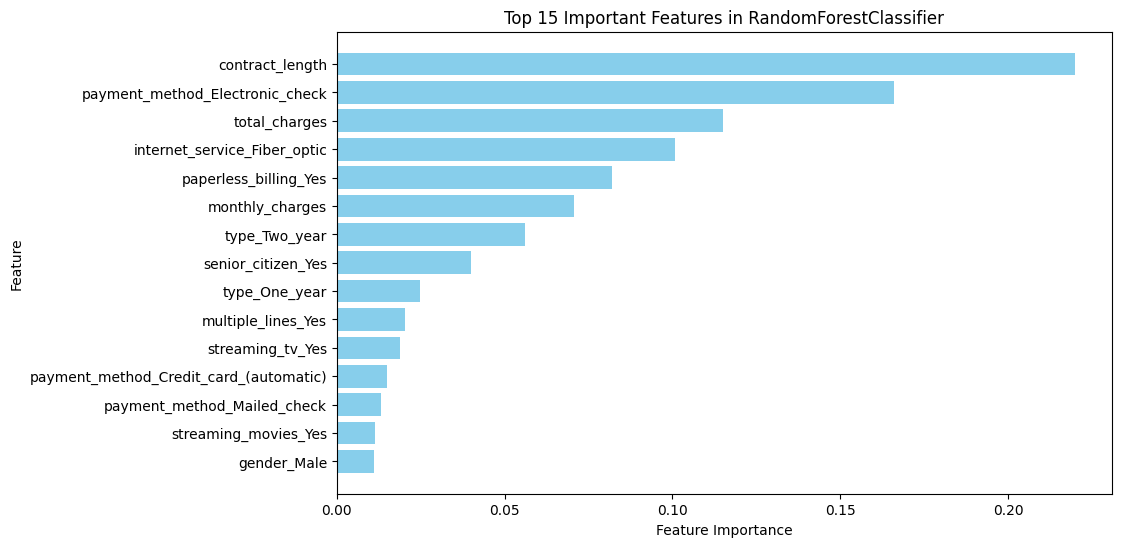

In [ ]:
# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to pair feature names with importance values
feat_importance_df = pd.DataFrame({
    'Feature': X_train_resampled.columns, 
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_df['Feature'][:15], feat_importance_df['Importance'][:15], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 15 Important Features in RandomForestClassifier")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

#### Random Forest Conclusions####
This model already is above the .85 threshold for Interconnect's desired Auc-Roc Score. This model could be a potential option for our final model. With hyperparameter tuning I was able to increase the Auc-Roc Score from .84 to .86

### Logistic Regression

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500]
}

lr_model = LogisticRegression()
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)
print(grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
lr = LogisticRegression(random_state=8420, solver='liblinear', C=1, max_iter=100, penalty='l2')
train_auc_roc, test_auc_roc, accuracy = train_evaluate_model(lr, X_train_resampled, y_train_resampled, X_test, y_test)

Train Auc-Roc: 0.89
Test AUC-ROC: 0.81
Test Accuracy: 0.76


#### Logistic Regression Conclusion ####
Even after tuning the hyperparameters, this model does not meet the threshold of at least .85. The Auc-Roc score of .81 eliminates this model from being a possible tool for Interconnect. 

### LightGBM Classifier

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'learning_rate': 0.2, 'max_depth': 7, 'min_data_in_leaf': 5, 'n_estimators': 200, 'num_leaves': 30}


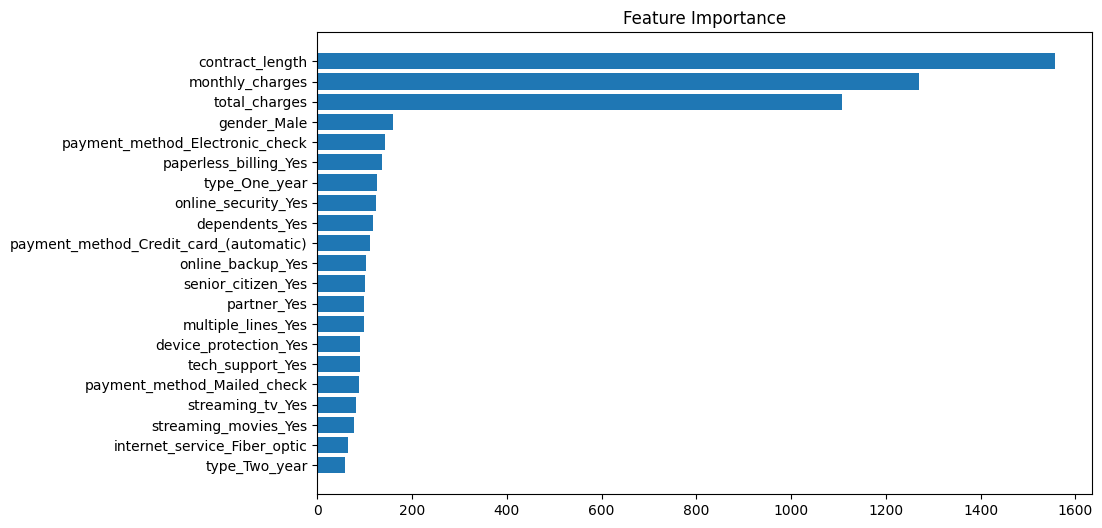

In [ ]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 30],
    'learning_rate': [.1, .2],
    'min_data_in_leaf': [5, 10, 20]
}

# Initialize model
lgbm_model = LGBMClassifier(random_state=8420, force_row_wise=True, verbose=-1)

# Perform grid search
grid_search = GridSearchCV(lgbm_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters
print(grid_search.best_params_)

# Train model with best parameters
best_model = LGBMClassifier(**grid_search.best_params_)
best_model.fit(X_train_resampled, y_train_resampled)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train_resampled.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.show()

In [ ]:
lgbm = LGBMClassifier(random_state=8420, num_leaves=30, max_depth=7, learning_rate=.2, n_estimators=200, min_data_in_leaf=5, force_row_wise=True, verbose=-1)

train_auc_roc, test_auc_roc, accuracy = train_evaluate_model(lgbm, X_train_resampled, y_train_resampled, X_test, y_test)

Train Auc-Roc: 1.00
Test AUC-ROC: 0.90
Test Accuracy: 0.86


#### Light GBM Conclusion ####
The Light GBM model proves to be an exceptional predictor of churn coming in with an Auc-Roc score of .90. This score far outstrips the other models and is the best contender for the final model. 

Also, in the process of hyperparameter tuning and the warnings that the model gave, it alerted me to several features that were causing noise in the model by having no importance to the classification prediction process. I used that information to remove many features. 

In addition to showing features that had no importance, this also showed me that contract length, monthly charges, and total charges were the most important features for the model to perform. These will be the final features that Interconnect will want to consider in their business strategies. 

### XGB Classifier

In [ ]:
# Define hyperparameter grid
param_grid = {
    'min_child_weight': [4, 6],
    'max_depth': [7, 10],
    'alpha': [5, 10],
    'eta': [.1, .2],
    'n_estimators': [200, 250]
}

# Initialize model
xgb_model = XGBClassifier(random_state=8420)

# Perform grid search
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters
print(grid_search.best_params_)


{'alpha': 5, 'eta': 0.2, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 250}


In [ ]:
xgb = XGBClassifier(alpha=5, min_child_weight=4, max_depth=7, eta=.2,n_estimators=250, random_state=8420)
train_auc_roc, test_auc_roc, accuracy = train_evaluate_model(xgb, X_train_resampled, y_train_resampled, X_test, y_test)

Train Auc-Roc: 0.99
Test AUC-ROC: 0.88
Test Accuracy: 0.83


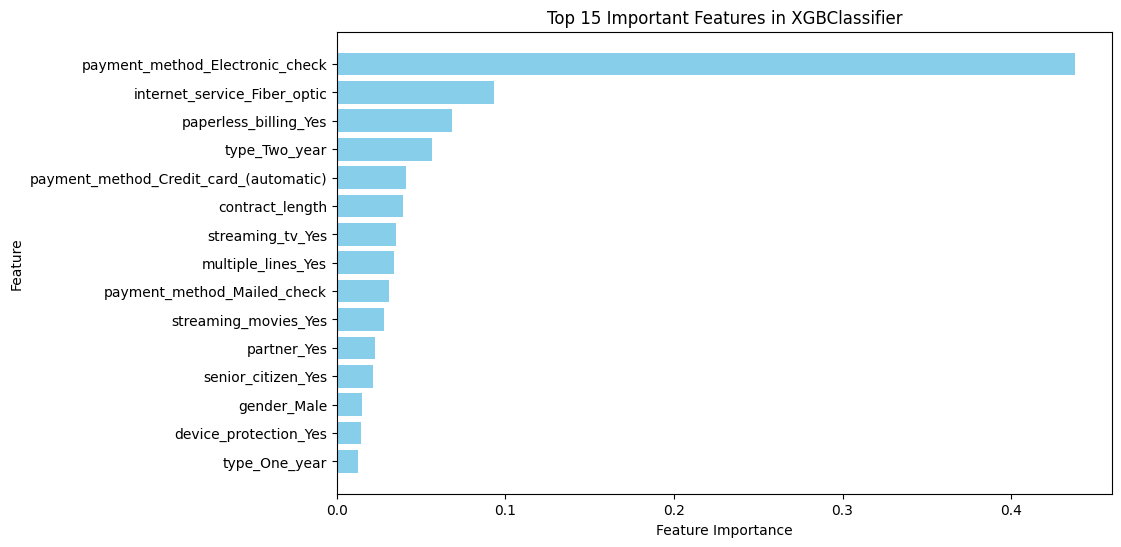

In [ ]:
# Get feature importances
feature_importances = xgb.feature_importances_

# Create a DataFrame to pair feature names with importance values
feat_importance_df = pd.DataFrame({
    'Feature': X_train_resampled.columns, 
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_df['Feature'][:15], feat_importance_df['Importance'][:15], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 15 Important Features in XGBClassifier")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

#### XGB Model ####
This model after hyperparameter tuning could also be a good final model for our task. The Auc-Roc score increased from .86 to .88. This model could potentially be even better tuned moving forward. Since this model achieved the .88 threshold it would be worth further consideration as the final model.

## Conclusion ##

Process: Interconnect tasked me with creating a predictive model that could guess which customers were most likely to cancel their services. They provided data from 4 different CSV files that needed to be cleaned and merged. In these files were begin and end date columns, from which I calculated the length of contract and the churn target. Any observaton that did not have an end date represented a current customer. After completing this task if was evident that of the 7000 observations, 26.5% were from customers who have chosen to cancel their subscription to Interconnect's services.

As a result of the class imbalance in the churn feature I needed to use an upsampling strategy to create balance. I opted for using SMOTE to increase the number of samples in the minority class (churned customers). This strategy creates new data points by interpolating between other observations that are nearby. I chose this to avoid overfitting the data. 

Once the churn feature was balanced, I used One-Hot encoding on the data because most of the columns were object data types. By encoding the data in this way, each column was represented numerically and was ready for machine learning.

Random Forest Classifier: The random forest classifier produced impressive results from the very beginning showing a final Auc-Roc score of .86. This model is a possible fit for Interconnect. However, other models ended up performing even better than this one.

Logistic Regression: Of the 4 models created, Logistic Regression was the only model unable to produce an acceptable Auc-Roc Score. I was only able to get it to produce a score of .81 at its best. So I do not recommend Interconnect to use this model.

Light GBM: This model was the top performing model of the group achieving a Auc-Roc score of .90. With this impressive result, and the speed of the model itself, this would be my top recommendation for Interconnect to use. If the dataset were much larger than this one, this model would be a better choice for predictions.

XGB Classifier: The XGB model was also able to provide an exceptional Auc-Roc score of .88. This value makes this model a great option for interconnect.

Final Recommendation: The best performing model of the 4 used in this project what the LightGBM model. As a result, I recommend that Interconnect use this model for predicting which customers are at the higest risk of cancelling their services.

It was also evident from the LGBM model that the most important features for predicting churn were the Contract Length, Monthly Charges, and Total Charges features. Interconnect would benefit from creating strategies in these 3 areas to decrease churn rates. 

The XGB Model found other features to be of higher importance, Specifically the Electronic Check payment method. This accounted for more than 40% of the predictive weight with that model. This was also shown in the charts above. Perhaps Interconnect had some issues with their billing system particularly with the E Check feature, so this would also be an important place for further investigation and imrovement.

The Random Forest model also provided significant insight into issues that are connected to the churn observations in Interconnect's data. The 4 most important features in creating predictions were: Contract Length, Electonic Checks, Fiber Optic Service, and Total Charges. Again, Interconnect will do well to explore these features further for continued improvement for their services.

## Solution Report ##

#### Steps of the plan performed and skipped:
In this project I wrote a plan that consisted of 10 stages, and I carried out the plan to complete the project. There were a few details from the original plan that I chose to do slightly differently. For example, I did feature engineering concurrently with the preprocessing as the two processes affected one another in the end.

I also chose not to use the Upsampling method with this data and only used SMOTE I explain this decision making process below, but I believed that it was the superior strategy for this data. I also chose not to build at CatBoost model. This was simply a function of getting the desired results from the LightGBM and XGBoost classifier models. Since both of these models were able to achieve the scores needed for the task, it seemed to me to be an unnecessary duplication of effort for producing another model. If Interconnect wanted another model to meet those standards however, I would be happy to proceed with building that model as well. 

I added a step with the successful models that I believe is important for making business decisions based on the findings from this project. That step was to check which features were most important for each models' decision process. By looking at which featueres were most important I believe that Interconnect can improve the quality of their product for their customers. This process also showed a few places in my preparation of the data that created more noise for the final models, so I was able to use that information to clean the data even further and provide a better final product.

#### Difficulties and steps to resolve them:
With this data set being rather small compared to many of the other data sets we've used in other projects, I needed to make sure to preserve as much data as possible. This meant when merging the data there would be a lot of NaN values that I had to fill with "Unknown". Later, when I checked feature importance for the LightGBM model, I found that many of the "Unknown" columns that were created during the One-Hot Encoding process were simply adding noise as they didn't provide any useful information for the model building process. Since they were just noise, I chose to remove them and progress with the model tuning process.

I needed to choose between upsampling and SMOTE to deal with the class imbalance in the data set. Since this data is so small, upsampling didn't seem to be a great option as it would have just duplicated observations from the minority class until there was balance. There wouldn't be enough diversity within the data to create a quality prediction. So I opted to use SMOTE instead so that all of the new observations added to the data would be slight variations of the existing data. This proved to be an effective strategy for this data.

#### Key steps for solving the task:
I believe that there were a few key steps to solving this task efficiently. The final LightGBM model found that three features - Contract Length, Monthly Charges, and Total Charges were the most important for quality predictions on the test set. The Contract Length feature did not exist in the original data. I had to create it by transforming the BeginDate and EndDate Columns into subtractable times to then create the new feature, Contract Length. 

It was also helpful to deal with class imbalance by using the SMOTE strategy. By using this method I was able to aquire new usable samples for training that gave each model better observations from which to make predictions.

Finally I was able to achieve better results with each of the models by tuning the hyperparameters using a Gridsearch. This helped bring the final scores up to the desired levels. 
 
#### Final model quality score:
The final model uses the LightGBM Classifier and was able to achieve a .90 Auc-Roc score. 
